In [121]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score,accuracy_score,roc_auc_score,confusion_matrix,classification_report
from sklearn.feature_extraction import DictVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns



In [122]:
df = pd.read_csv('data/ObesityDataSet.csv')
df.isna().sum()


Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

There are no null values in the columns but there are 24 duplicated rows.Lets remove them from the dataset

In [123]:
print("Number of duplicated rows:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("Number of duplicated rows after removing:", df.duplicated().sum())
df.shape

Number of duplicated rows: 24
Number of duplicated rows after removing: 0


(2087, 17)

First lets understand the features of this Obesity dataset to explore about them. There are 17 columns namely,

Attributes related to eating habits
* CALC Consumption of Alcohol
* FAVC Frequent consumption of high caloric food
* FCVC Frequency of consumption of vegetables
* NCP  Number of main meals
* SMOKE smoker or non-smoker
* CH2O  Consumption of water daily
* CAEC  Consumption of food between meals

Attributes related to physical condition
* Age, Gender, Height and weight columns are self explanatory
* family_history_with_overweight - does he have family history of overweight
* SCC  Calories consumption monitoring
* FAF   Physical activity frequency
* TUE   Time using technology devices
* MTRANS Transportation used
* NObeyesdad Target variable predicts if he is normal or obese

gender                            0.210643
caec                              0.156140
family_history_with_overweight    0.156009
calc                              0.107467
mtrans                            0.079317
favc                              0.063315
scc                               0.038011
smoke                             0.008509


In [124]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(' ', '_').str.lower()
df.isnull().sum()
categorical_cols = list(df.dtypes[df.dtypes == 'object'].index)
numerical_cols = list(df.dtypes[df.dtypes != 'object'].index)
numerical_cols


['age', 'height', 'weight', 'fcvc', 'ncp', 'ch2o', 'faf', 'tue']

There are no missing values in this dataset. Basic datacleaning is done 

In [125]:
for c in categorical_cols:
    print("feature : ",c,df[c].unique())
for c in numerical_cols:
    print("feature : ",c,df[c].describe())
    print()

feature :  gender ['female' 'male']
feature :  calc ['no' 'sometimes' 'frequently' 'always']
feature :  favc ['no' 'yes']
feature :  scc ['no' 'yes']
feature :  smoke ['no' 'yes']
feature :  family_history_with_overweight ['yes' 'no']
feature :  caec ['sometimes' 'frequently' 'always' 'no']
feature :  mtrans ['public_transportation' 'walking' 'automobile' 'motorbike' 'bike']
feature :  nobeyesdad ['normal_weight' 'overweight_level_i' 'overweight_level_ii'
 'obesity_type_i' 'insufficient_weight' 'obesity_type_ii'
 'obesity_type_iii']
feature :  age count    2087.000000
mean       24.353090
std         6.368801
min        14.000000
25%        19.915937
50%        22.847618
75%        26.000000
max        61.000000
Name: age, dtype: float64

feature :  height count    2087.000000
mean        1.702674
std         0.093186
min         1.450000
25%         1.630178
50%         1.701584
75%         1.769491
max         1.980000
Name: height, dtype: float64

feature :  weight count    2087.000

Let's check the correlation coefficient for numerical values in the training dataset after doing the test split

In [126]:
df_fulltrain,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_train,df_val =train_test_split(df_fulltrain, test_size=0.25, random_state=42)
df_fulltrain = df_fulltrain.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train['nobeyesdad']
y_val = df_val['nobeyesdad']
y_test = df_test['nobeyesdad']  
y_fulltrain = df_fulltrain['nobeyesdad']
  


Let us plot the distribution of target variable to understand the obesity levels of people

insufficient_weight : 267
normal_weight : 282
obesity_type_i : 351
obesity_type_ii : 297
obesity_type_iii : 324
overweight_level_i : 276
overweight_level_ii : 290
Min samples in a class : 267
Max samples in a class : 351
Class Imbalance Ratio : 1.3146067415730338


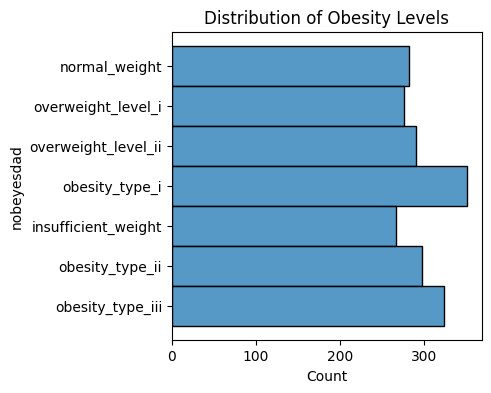

In [127]:
plt.figure(figsize=(4, 4))
sns.histplot(y=df.nobeyesdad, bins=50)
plt.title('Distribution of Obesity Levels')
del df_train['nobeyesdad']
del df_val['nobeyesdad']
del df_test['nobeyesdad'] 

class_names = ['insufficient_weight', 'normal_weight', 'obesity_type_i', 'obesity_type_ii','obesity_type_iii','overweight_level_i','overweight_level_ii']
min=0
max=0
for c in class_names:
    sum = (df.nobeyesdad == c).sum()
    print(c, ":", sum)
    if min ==0 or sum < min:
        min = sum
    if sum > max:
        max = sum
print("Min samples in a class :", min)
print("Max samples in a class :", max)  
class_imbalance_ratio = max / min
print("Class Imbalance Ratio :", class_imbalance_ratio)   

class imbalance ratio is 1.31 <2 =>well balanced dataset

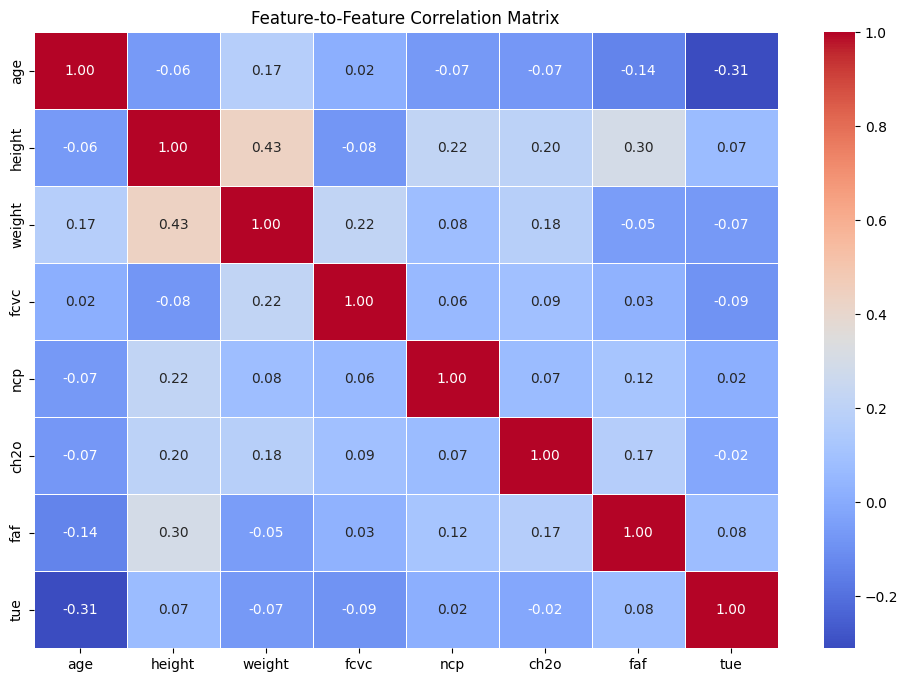

In [128]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature-to-Feature Correlation Matrix")
plt.show()



From the heatmap , it is clear that all values of |r|<0.5 ==> all numerical features are distinct and are not redundant.So we can retain all the numerical features. Let's calculate Mutual Information Score for categorical values.

In [129]:

if 'nobeyesdad' in categorical_cols:
    categorical_cols.remove('nobeyesdad')
print(categorical_cols)
print(numerical_cols)
def mutual_info_score_series(series):
    return mutual_info_score(series,y_train)

mi=df_train[categorical_cols].apply(mutual_info_score_series)
mi.sort_values(ascending=False)

['gender', 'calc', 'favc', 'scc', 'smoke', 'family_history_with_overweight', 'caec', 'mtrans']
['age', 'height', 'weight', 'fcvc', 'ncp', 'ch2o', 'faf', 'tue']


gender                            0.210643
caec                              0.156140
family_history_with_overweight    0.156009
calc                              0.107467
mtrans                            0.079317
favc                              0.063315
scc                               0.038011
smoke                             0.008509
dtype: float64

From Mutual Information score it is clear that smoke  has very low MI score .But removing that feature had no effect on the roc score.
Let's create a confusion matrix  and classification report to undertand recall,precision and f1 scores


Accuracy: 0.876
ROC AUC: 0.983
Confusion Matrix:
 [[46  1  0  0  0  0  0]
 [ 7 49  0  0  0  8  3]
 [ 0  0 56  3  0  0  4]
 [ 0  0  4 54  0  0  0]
 [ 0  0  0  0 63  0  0]
 [ 0  4  0  0  0 55  9]
 [ 0  1  3  1  0  4 43]]

Classification Report:
                      precision    recall  f1-score   support

insufficient_weight       0.87      0.98      0.92        47
      normal_weight       0.89      0.73      0.80        67
     obesity_type_i       0.89      0.89      0.89        63
    obesity_type_ii       0.93      0.93      0.93        58
   obesity_type_iii       1.00      1.00      1.00        63
 overweight_level_i       0.82      0.81      0.81        68
overweight_level_ii       0.73      0.83      0.77        52

           accuracy                           0.88       418
          macro avg       0.88      0.88      0.88       418
       weighted avg       0.88      0.88      0.88       418



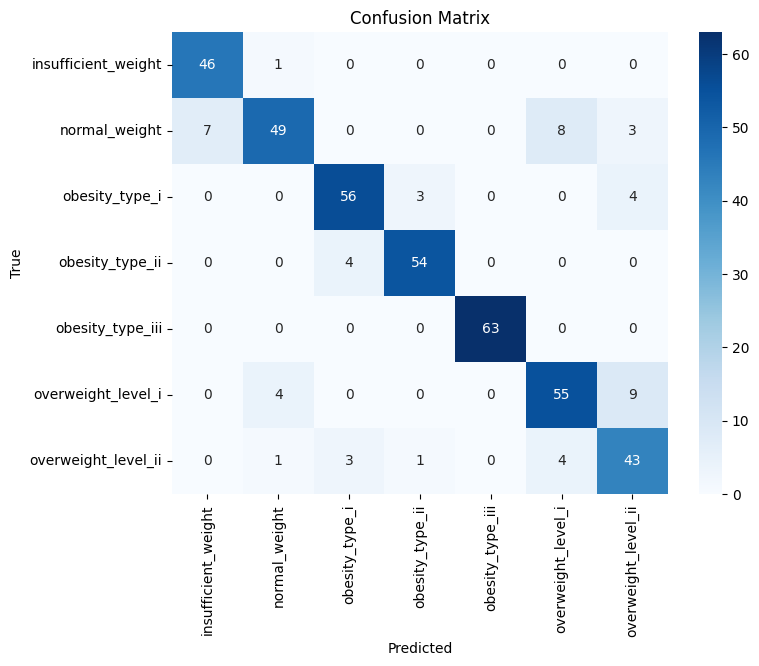

In [ ]:
Model_ROC_AUC_scores = []
def train(df,y,C):
    dv =DictVectorizer(sparse=False)
    dicts = df.to_dict(orient='records')
    X = dv.fit_transform(dicts)
    model = LogisticRegression(C=C,solver='newton-cg', penalty='l2', max_iter=1000 ,random_state=42)
    model.fit(X, y)     
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts) 
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    return y_pred, y_pred_proba

dv, model = train(df_train, y_train, C=10)
y_pred, y_pred_proba = predict(df_val, dv, model)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", np.round(accuracy, 3))
roc_auc = roc_auc_score(y_val, y_pred_proba,multi_class='ovr')
print("ROC AUC:", np.round(roc_auc, 3))
Model_ROC_AUC_scores.append(('Logistic Regression', roc_auc))

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_pred))


# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['insufficient_weight', 'normal_weight', 'obesity_type_i', 'obesity_type_ii','obesity_type_iii','overweight_level_i','overweight_level_ii'], yticklabels=['insufficient_weight', 'normal_weight', 'obesity_type_i', 'obesity_type_ii','obesity_type_iii','overweight_level_i','overweight_level_ii'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Let's check the model with cross-validation

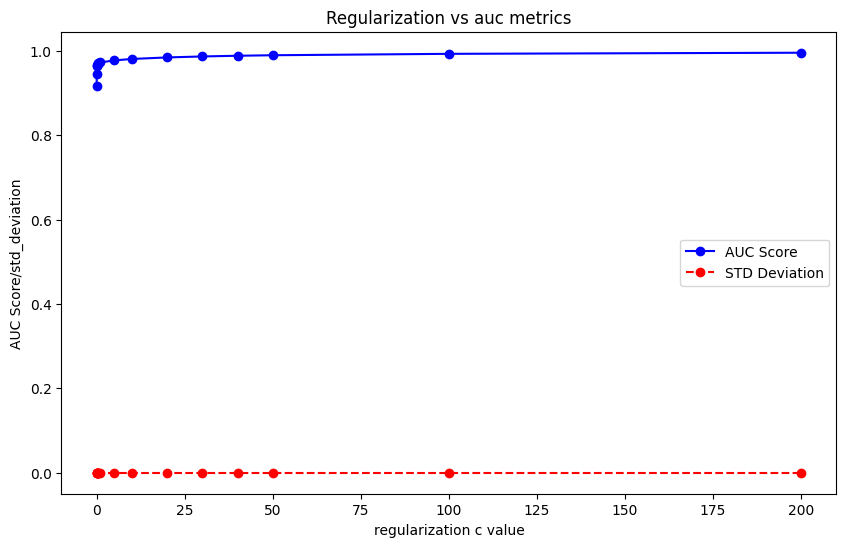

In [ ]:
n_splits = 5
mean_scores=[]
std_deviation= []
reg_params = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 30, 40, 50,100,200]
for C in reg_params:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_fulltrain):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.nobeyesdad.values
        y_val = df_val.nobeyesdad.values
        del df_train['nobeyesdad']
        del df_val['nobeyesdad']

        dv, model = train(df_train, y_train, C=C)
        y_pred,y_pred_proba = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred_proba,multi_class='ovr')

    scores.append(auc)
    mean_scores.append(np.mean(scores))
    std_deviation.append(np.std(scores))

        
    # Plotting the AUC scores
plt.figure(figsize=(10, 6))
plt.plot(reg_params, mean_scores, marker='o', linestyle='-', color='b', label='AUC Score')
plt.plot(reg_params, std_deviation, marker='o', linestyle='--', color='r', label='STD Deviation')
plt.xlabel('regularization c value')
plt.ylabel('AUC Score/std_deviation')
plt.title('Regularization vs auc metrics')
plt.legend()
plt.show()



From cross-validation using Kfold it is clear that at C=100 the roc score is maximum.But at c=10 the roc_auc is close to optimum 0.986.So lets choose C=10 as our final regularization value
Lets train a final model combining both training and validation dataset and calculate roc_score against test dataset

In [ ]:
y_fulltrain = df_fulltrain.nobeyesdad
del df_fulltrain['nobeyesdad']
dv,model = train(df_fulltrain, y_fulltrain, C=10)
y_test, y_test_proba = predict(df_test, dv, model)

roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
classification_rep = classification_report(y_test, y_test)
print("Classification Report on test data:\n", classification_rep)
print("LogisticRegression Model ROC AUC with test data: ", np.round(roc_auc, 3))



Classification Report on test data:
                      precision    recall  f1-score   support

insufficient_weight       1.00      1.00      1.00        66
      normal_weight       1.00      1.00      1.00        51
     obesity_type_i       1.00      1.00      1.00        73
    obesity_type_ii       1.00      1.00      1.00        66
   obesity_type_iii       1.00      1.00      1.00        61
 overweight_level_i       1.00      1.00      1.00        57
overweight_level_ii       1.00      1.00      1.00        44

           accuracy                           1.00       418
          macro avg       1.00      1.00      1.00       418
       weighted avg       1.00      1.00      1.00       418

LogisticRegression Model ROC AUC with test data:  1.0


After training the model with both validation and training data, it is tested with test data , we get optimum result with roc_score of 1.0 Moving on to decisiontree to check the performance

Decision Tree with depth 1 Accuracy: 0.27627627627627627 ROC AUC: 0.7125098647379134
Decision Tree with depth 2 Accuracy: 0.5465465465465466 ROC AUC: 0.8453969738063011
Decision Tree with depth 3 Accuracy: 0.6216216216216216 ROC AUC: 0.9172588911322899
Decision Tree with depth 4 Accuracy: 0.7867867867867868 ROC AUC: 0.9483733961724399
Decision Tree with depth 5 Accuracy: 0.8438438438438438 ROC AUC: 0.9719350319484272
Decision Tree with depth 6 Accuracy: 0.8798798798798799 ROC AUC: 0.9734292883093599
Decision Tree with depth 7 Accuracy: 0.8888888888888888 ROC AUC: 0.9674849189563639
Decision Tree with depth 8 Accuracy: 0.918918918918919 ROC AUC: 0.9643754536453593
Decision Tree with depth 9 Accuracy: 0.918918918918919 ROC AUC: 0.9548041985618668
Decision Tree with depth 10 Accuracy: 0.9309309309309309 ROC AUC: 0.9608278029142033
Decision Tree with depth 11 Accuracy: 0.9279279279279279 ROC AUC: 0.9576201579109647
Decision Tree with depth 12 Accuracy: 0.9279279279279279 ROC AUC: 0.9582455

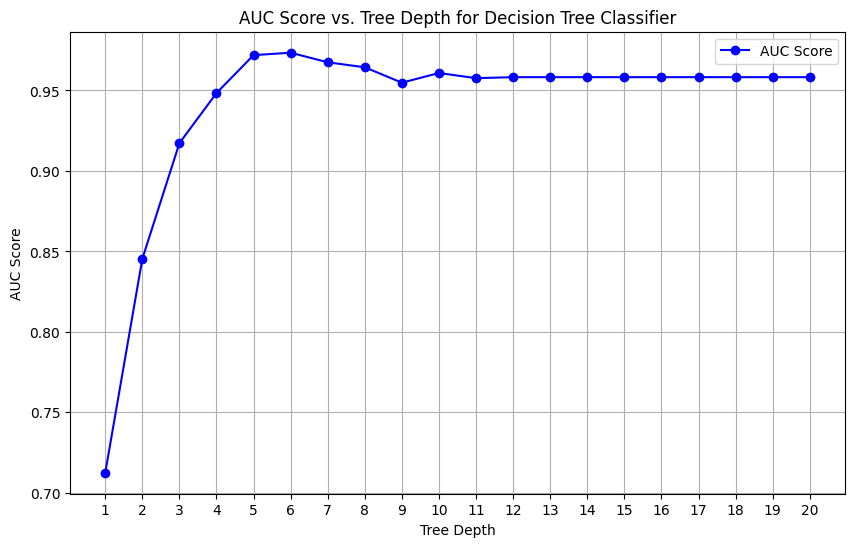

In [ ]:
dv= DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

auc_scores = []
depths = range(1, 21)
for max_depth in depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) 
    roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
    print("Decision Tree with depth " \
    f"{max_depth} Accuracy:", accuracy,"ROC AUC:", roc_auc)

    auc_scores.append(roc_auc)

# Plotting the AUC scores
plt.figure(figsize=(10, 6))
plt.plot(depths, auc_scores, marker='o', linestyle='-', color='b', label='AUC Score')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Tree Depth for Decision Tree Classifier')
plt.grid(True)
plt.xticks(depths)  # Ensure we show all depth values on the x-axis
plt.legend()
plt.show()



Decision trees parameter tuning max_depth=5, 6, 7 and 8 have high ROC score.Lets find out the best values for min_sample_leaves

max_depth: 5, min_samples_leaf: 1, Accuracy: 0.8438438438438438, ROC AUC: 0.9719350319484272
max_depth: 5, min_samples_leaf: 2, Accuracy: 0.8408408408408409, ROC AUC: 0.9665806482376379
max_depth: 5, min_samples_leaf: 3, Accuracy: 0.8378378378378378, ROC AUC: 0.9665622293177233
max_depth: 5, min_samples_leaf: 4, Accuracy: 0.8228228228228228, ROC AUC: 0.9637007608805819
max_depth: 5, min_samples_leaf: 5, Accuracy: 0.8228228228228228, ROC AUC: 0.9637286250421523
max_depth: 5, min_samples_leaf: 10, Accuracy: 0.8318318318318318, ROC AUC: 0.9649220649868365
max_depth: 5, min_samples_leaf: 15, Accuracy: 0.8228228228228228, ROC AUC: 0.9650028955195239
max_depth: 5, min_samples_leaf: 20, Accuracy: 0.8168168168168168, ROC AUC: 0.9640188342281997
max_depth: 5, min_samples_leaf: 25, Accuracy: 0.8228228228228228, ROC AUC: 0.9665514794839604
max_depth: 5, min_samples_leaf: 50, Accuracy: 0.7177177177177178, ROC AUC: 0.947513827995159
max_depth: 5, min_samples_leaf: 100, Accuracy: 0.6726726726726727,

<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

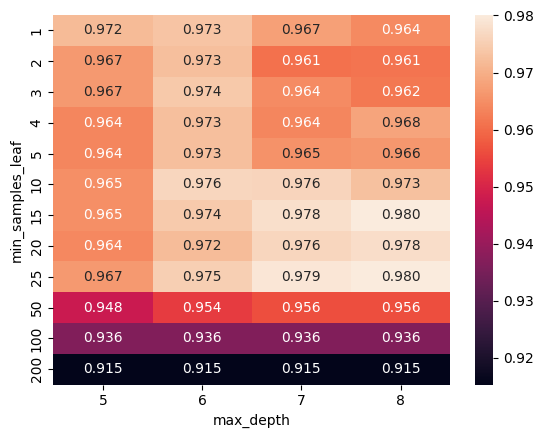

In [ ]:
scores = []
for max_depth in [5, 6, 7, 8]:
    for min_samples_leaf in [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred) 
        roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
        scores.append({
            'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })
        print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, Accuracy: {accuracy}, ROC AUC: {roc_auc}")
df_scores = pd.DataFrame(scores)
pivot_table = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='roc_auc')
sns.heatmap(pivot_table, annot=True, fmt=".3f") 

From the pivot table it is clear that for max_depth =8 and min_sample_leaves =15, we get best ROC_AUC 0.980 
The model is tested with testdata and  the scores ROC_AUC score is 0.978 which is almost same as validation ROC_AUC. 
This confirms that DecisionTree model is not overfitting and consistent in prediction

In [ ]:
dt = DecisionTreeClassifier(max_depth=7,min_samples_leaf=15, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
accuracy = accuracy_score(y_val, y_pred) 
roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
print("Decision Tree with validationdata Accuracy:", accuracy,"ROC AUC:", roc_auc)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))
Model_ROC_AUC_scores.append(('Decision Tree', roc_auc))

Decision Tree with validationdata Accuracy: 0.8918918918918919 ROC AUC: 0.9780265040566016
|--- weight <= 99.92
|   |--- weight <= 61.71
|   |   |--- height <= 1.66
|   |   |   |--- weight <= 46.83
|   |   |   |   |--- weight <= 44.78
|   |   |   |   |   |--- class: insufficient_weight
|   |   |   |   |--- weight >  44.78
|   |   |   |   |   |--- class: insufficient_weight
|   |   |   |--- weight >  46.83
|   |   |   |   |--- height <= 1.54
|   |   |   |   |   |--- class: overweight_level_i
|   |   |   |   |--- height >  1.54
|   |   |   |   |   |--- age <= 18.81
|   |   |   |   |   |   |--- class: normal_weight
|   |   |   |   |   |--- age >  18.81
|   |   |   |   |   |   |--- weight <= 52.50
|   |   |   |   |   |   |   |--- class: normal_weight
|   |   |   |   |   |   |--- weight >  52.50
|   |   |   |   |   |   |   |--- class: normal_weight
|   |   |--- height >  1.66
|   |   |   |--- weight <= 55.00
|   |   |   |   |--- class: insufficient_weight
|   |   |   |--- weight >  55.00
| 

Now let's train Ensemble Forest Classifier model

n_estimators: 10, Accuracy: 0.8828828828828829, ROC AUC: 0.9811746075039922
n_estimators: 20, Accuracy: 0.9039039039039038, ROC AUC: 0.9844050409735432
n_estimators: 30, Accuracy: 0.9009009009009009, ROC AUC: 0.9859142132647122
n_estimators: 40, Accuracy: 0.9009009009009009, ROC AUC: 0.9873389041381345
n_estimators: 50, Accuracy: 0.8978978978978979, ROC AUC: 0.9871296040403372
n_estimators: 60, Accuracy: 0.8948948948948949, ROC AUC: 0.9890106027046742
n_estimators: 70, Accuracy: 0.8888888888888888, ROC AUC: 0.9890921756712773
n_estimators: 80, Accuracy: 0.8888888888888888, ROC AUC: 0.9893421565495271
n_estimators: 90, Accuracy: 0.8888888888888888, ROC AUC: 0.9899926708722073
n_estimators: 100, Accuracy: 0.8888888888888888, ROC AUC: 0.9902432057171092
n_estimators: 110, Accuracy: 0.8918918918918919, ROC AUC: 0.9907488022913707
n_estimators: 120, Accuracy: 0.8948948948948949, ROC AUC: 0.9909340110504817
n_estimators: 130, Accuracy: 0.9009009009009009, ROC AUC: 0.9909743489306561
n_estima

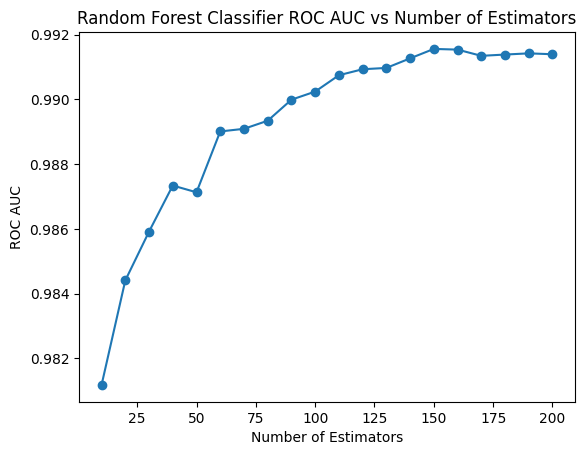

|--- weight <= 99.41
|   |--- family_history_with_overweight=no <= 0.50
|   |   |--- scc=no <= 0.50
|   |   |   |--- caec=sometimes <= 0.50
|   |   |   |   |--- calc=frequently <= 0.50
|   |   |   |   |   |--- faf <= 1.50
|   |   |   |   |   |   |--- age <= 17.50
|   |   |   |   |   |   |   |--- class: 5.0
|   |   |   |   |   |   |--- age >  17.50
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- faf >  1.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- calc=frequently >  0.50
|   |   |   |   |   |--- height <= 1.70
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- height >  1.70
|   |   |   |   |   |   |--- class: 5.0
|   |   |   |--- caec=sometimes >  0.50
|   |   |   |   |--- ch2o <= 1.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- ch2o >  1.50
|   |   |   |   |   |--- age <= 17.73
|   |   |   |   |   |   |--- class: 5.0
|   |   |   |   |   |--- age >  17.73
|   |   |   |   |   |   |--- gender=male <= 0.50
|   |   |   |  

In [ ]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) 
    roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val), multi_class='ovr')
    scores.append({
        'n_estimators': n,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    })
    print(f"n_estimators: {n}, Accuracy: {accuracy}, ROC AUC: {roc_auc}")
df_scores = pd.DataFrame(scores)
plt.plot(df_scores['n_estimators'], df_scores['roc_auc'], marker='o')
plt.xlabel('Number of Estimators')  
plt.ylabel('ROC AUC')
plt.title('Random Forest Classifier ROC AUC vs Number of Estimators')
plt.show()  
print(export_text(rf.estimators_[0], feature_names=list(dv.get_feature_names_out())))

Ensemble Random forest model gave best ROC_AUC of 0.991 with n_estimators =110.
let's check with test data how the Random forest is performing

In [ ]:
rf = RandomForestClassifier(n_estimators=110, random_state=42)
rf.fit(X_train, y_train)

df_val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(df_val_dicts)
y_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred) 
roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val), multi_class='ovr')
print("Random Forest with Validation Data Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))
Model_ROC_AUC_scores.append(('Random Forest', np.round(roc_auc, 3)))

df_test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(df_test_dicts)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
print("Random Forest with TestData Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))



Random Forest with Validation Data Accuracy: 0.892 ROC AUC: 0.991
Random Forest with TestData Accuracy: 0.885 ROC AUC: 0.986


Random Forest with Validation Data Accuracy: 0.892 ROC AUC: 0.991
Random Forest with TestData Accuracy: 0.885 ROC AUC: 0.986
This confirms that model is stable.
Almost same ROC_AUC score can be seen for all the models that we have evaluated so far.
Lets plot graph to evaluate the models

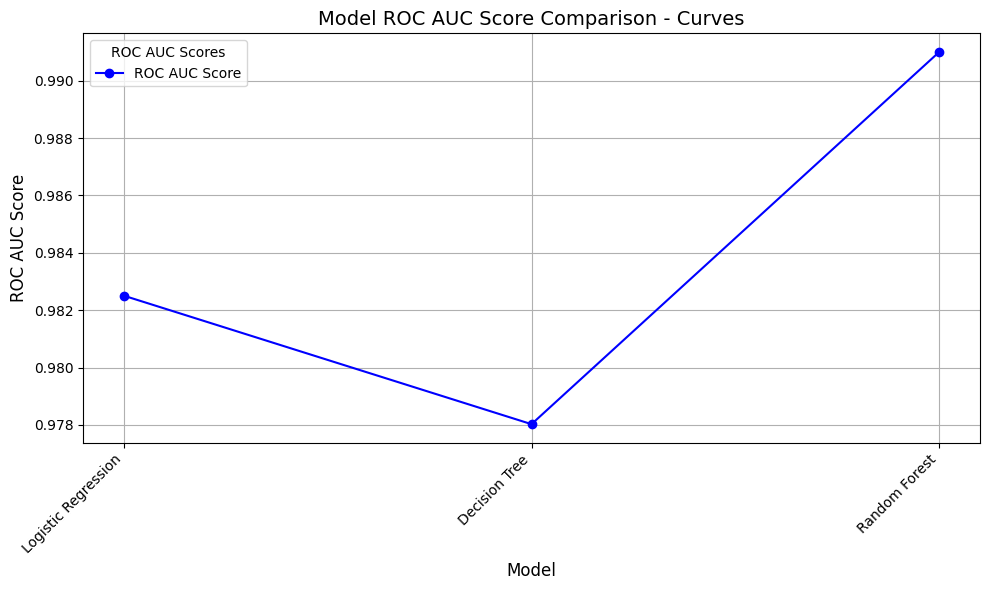

In [ ]:
Model, ROC_AUC_Score = zip(*Model_ROC_AUC_scores)
# Plotting the ROC AUC comparison using curves (line plot)
plt.figure(figsize=(10, 6))

# Plot the ROC AUC scores for each model
plt.plot(Model, ROC_AUC_Score, marker='o', linestyle='-', color='b', label='ROC AUC Score')

# Add labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.title('Model ROC AUC Score Comparison - Curves', fontsize=14)

# Add a legend to identify the line
plt.legend(title='ROC AUC Scores', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

From the graph, it is clear that all models give the same ROC_AUC score.Let's finalize the simple LogisticRegression model
for deployment

In [ ]:
for n in numerical_cols:
    print(df[n].describe())
    print()

for c in categorical_cols:
    print(df[c].value_counts())
    print()


count    2087.000000
mean       24.353090
std         6.368801
min        14.000000
25%        19.915937
50%        22.847618
75%        26.000000
max        61.000000
Name: age, dtype: float64

count    2087.000000
mean        1.702674
std         0.093186
min         1.450000
25%         1.630178
50%         1.701584
75%         1.769491
max         1.980000
Name: height, dtype: float64

count    2087.000000
mean       86.858730
std        26.190847
min        39.000000
25%        66.000000
50%        83.101100
75%       108.015907
max       173.000000
Name: weight, dtype: float64

count    2087.000000
mean        2.421466
std         0.534737
min         1.000000
25%         2.000000
50%         2.396265
75%         3.000000
max         3.000000
Name: fcvc, dtype: float64

count    2087.000000
mean        2.701179
std         0.764614
min         1.000000
25%         2.697467
50%         3.000000
75%         3.000000
max         4.000000
Name: ncp, dtype: float64

count    2087.0000